# Helmholtz 1D Multilevel: Constant Aggregate Size 
* Constant $k$.
* Discretization: 5-point (4th order).
* Fixed-domain problem; non-repetitive, so we generate TVs over entire domain.
* Fix aggregate size $a$ and $n_c$ (# principal components) over entire domain. Overlap the last two aggregates if needed.
* Optimize $a, n_c$ to maximize the mock cycle predicted error reduction efficiency.

In [30]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96
# Scaled wave number.
kh = 0.7

repetitive = True

# Number of test vectors.
num_examples = 20
threshold = 0.1

# Boottstrapping parameters.
threshold = 0.1
interpolation_method = "ls"
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

## Shrinkage Factor
Given an iterative method, we can calculate whether it's a good smoothing candidate using the **shrinkage factor** $\mu$, even before measuring its mock cycle rate (which measures the combination of the smoother andcoarsening operator $R$).

* Start from $5$ different random starts $x_0 = rand[-1,1]$, for each  apply the method for $A x = 0$ to obtain iterates $x_1, x_2, \dots$.
* For each iterate, calculate residual norm $r_i := \|A x_i\|_2$ and reduction per sweep, $\mu_i := (r_i / r_0)^{\frac{1}{i}}$, $i = 1, 2, \dots$.
* Average $\mu_i$ over the $5$ starts.
* Terminate the method at $j = i + 3$, where $i = argmin_i \mu_i$ and set $\mu \leftarrow \mu_j$.

## Level 0->1 Coarsening

### Relaxation Shrinkage Factor

PODR = point of diminishing returns
Efficiency = residual reduction per sweep
kh 0
Kac   conv 0.95 shrinkage 0.70 PODR RER 0.39 after  8 sweeps. Work  1 efficiency 0.70
GS    conv 0.88 shrinkage 0.50 PODR RER 0.15 after  6 sweeps. Work  1 efficiency 0.50
kh 0.7
Kac   conv 0.96 shrinkage 0.71 PODR RER 0.39 after  8 sweeps. Work  1 efficiency 0.71
GS    conv 1.55 shrinkage 0.50 PODR RER 0.74 after  2 sweeps. Work  1 efficiency 0.50


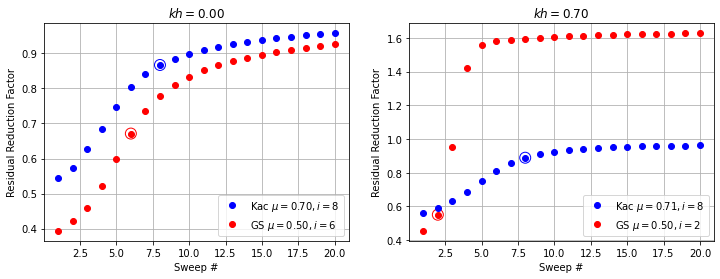

In [32]:
kh_values = [0, kh]
fig, axs = plt.subplots(1, len(kh_values), figsize=(12, 4))

kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)
work = 1

print("PODR = point of diminishing returns")
print("Efficiency = residual reduction per sweep")
# Kaczmarz.
for kh_value, ax in zip(kh_values, axs):
    print("kh", kh_value)
    a_kh = hm.linalg.helmholtz_1d_5_point_operator(kh_value, n).tocsr()
    operator = lambda x: a_kh.dot(x)

    for title, relax, color in zip(("Kac", "GS"), (kaczmarz, gs), ("blue", "red")):
        method = relax(a_kh)
        factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
            operator, lambda x, b: method.step(x, b), (a_kh.shape[0], ), 
            print_frequency=None, max_sweeps=20, slow_conv_factor=1.1, leeway_factor=leeway_factor)
        hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
        print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
            title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))
    
    ax.set_title(r"$kh = {:.2f}$".format(kh_value))
    ax.legend()

The point of diminishing returns in each scatterplot is circled.

This estimate seems to give a reasonable estimate for both $kh$ values and both relaxation schemes (albeit not a quantitative smoothing factor, which can only be defined based on a coarsening), showing that GS is a better smoother for both $kh = 0, 0.5$, but slightly diverges for $kh = 0.5$. The RER at the point of diminishing returns is much smaller.

Averaging over multiple random starts helps reduce noise, as well as assuming a constant reduction per sweep in the initial sweeps (as opposed to a linear model, say). We are only interested in a rough estimate.

**TODO: output asymptotic convergence factor a little past PODR to see if relax diverges.**

### Coarsening: Optimizing $a$, $n_c$

In [33]:
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
a0 = a
level = hm.setup.hierarchy.create_finest_level(a)

In [34]:
_LOGGER.info("kh {}".format(kh))
x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel(level)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))

factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    operator, lambda x, b: level.relax(x, b), (a_kh.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log.append(x)

_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

INFO     kh 0.7
INFO     Relax at level 0 size 96
INFO     Relax conv 0.93 shrinkage 0.65 PODR RER 0.59 after 5 sweeps. Work 1.0 eff 0.65
INFO     Generating TVs with 5 sweeps
INFO     RER 0.570


In [35]:
# Calculate mock cycle predicted efficiency.
aggregate_size_values = np.array([2, 4, 6])
nu_values = np.arange(1, 6, dtype=int)
# TODO: determine this based on cycle index.
max_conv_factor = 0.3

coarsener = hm.setup.coarsening_uniform.UniformCoarsener(level, x, aggregate_size_values, nu_values, repetitive=repetitive)
r, aggregate_size, nc, cr, mean_energy_error, nu, mock_conv, mock_work, mock_efficiency = \
    coarsener.get_optimal_coarsening(max_conv_factor)
print("kh {:.2f} R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle nu {} conv {:.2f} efficiency {:.2f}".format(
  kh, r.shape, aggregate_size, nc, cr, mean_energy_error, nu, mock_conv, mock_efficiency))

kh 0.70 R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.1737; mock cycle nu 3 conv 0.19 efficiency 0.76


In [36]:
info = coarsener.get_coarsening_info(1)
columns=("i", "a", "nc", "cr", "Energy Error", "nu", "conv", "work", "eff")
pd.DataFrame(info).rename(columns=dict(enumerate(columns))).astype(
    {"i": "int32", "a": "int32", "nc": "int32", "nu": "int32"})

,i,a,nc,cr,Energy Error,nu,conv,work,eff
0,0,2,1,0.50,0.35,1,0.64,2.00,0.80
1,0,2,1,0.50,0.35,2,0.34,4.00,0.77
2,0,2,1,0.50,0.35,3,0.24,6.00,0.79
3,0,2,1,0.50,0.35,4,0.25,8.00,0.84
4,0,2,1,0.50,0.35,5,0.24,10.00,0.87
5,1,4,1,0.25,0.46,1,0.86,1.33,0.89
6,1,4,1,0.25,0.46,2,0.88,2.67,0.95
7,1,4,1,0.25,0.46,3,0.88,4.00,0.97
8,1,4,1,0.25,0.46,4,0.87,5.33,0.97
9,1,4,1,0.25,0.46,5,0.85,6.67,0.98


The optimal coarsening (based on mock cycle efficiency) is for a larger aggregate ($4/2$) only for a sufficiently large $kh$, of $\approx 0.7$. Even at $kh = 0.5$, $2/1$ coarsening is (very slightly) better.

### Build Coarse Level: Two-level Bootstrap Cycle

In [37]:
max_levels = 2
num_bootstrap_steps = 1

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, neighborhood=neighborhood, repetitive=repetitive)
    x_log.append(x)
    r_log.append(multilevel.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

INFO     bootstrap on grid size 96 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.959 asymptotic RQ -0.016 RER 0.149 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (48, 96) a 4 nc 2 cr 0.50 mean_energy_error 0.0918; mock cycle nu 3 conv 0.19 eff 0.76
INFO     Mock cycle conv factor [0.631 0.318 0.188 0.12  0.147]
(120, 4) (120, 48)
(120, 4) (120, 48)
INFO     P max error: fit 0.065 val 0.080 test 0.088; alpha mean 0.000
INFO     fit  set size 15 P L2 error mean 0.04 max 0.06 A error mean 0.11 max 0.15
INFO     test set size 5  P L2 error mean 0.04 max 0.05 A error mean 0.10 max 0.11
INFO     Level 1 size 48
INFO     RER 0.241630
INFO     --------------------------------------------------------------------------------


### Interpolation Error

In [38]:
p = multilevel.level[1].p
r = multilevel.level[1].r
x_fit, x_test = x[:, :-num_test_examples], x[:, -num_test_examples:]
e = x - p.dot(r.dot(x))
error = norm(e, axis=0) / norm(x, axis=0)
error_a = norm(level.a.dot(e), axis=0) / norm(x, axis=0)
print(error_a)
print(e[2])
print(p[2].todense())
print(x[2])

[0.09  0.104 0.073 0.149 0.106 0.101 0.095 0.124 0.093 0.086 0.095 0.115 0.134 0.112 0.102 0.102 0.114 0.071 0.102 0.098]
[ 0.002  0.    -0.002 -0.005  0.002  0.     0.     0.     0.003 -0.001 -0.     0.002 -0.002  0.001 -0.003  0.001  0.001  0.003 -0.001  0.001]
[[ 0.63   0.321 -0.047  0.109  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]]
[-0.249  0.109 -0.017  0.216 -0.106  0.174 -0.04   0.035  0.066  0.039  0.154 -0.187  0.19  -0.098 -0.128 -0.025 -0.107 -0.15  -0.239  0.222]


### Level 1 Relaxation Shrinkage Factor

INFO     Iter     |r|                 |x|         RER
INFO     0     3.018e-01            4.469e-01    0.677
INFO     1     1.115e-01 (0.372)    2.692e-01    0.416 (0.617)
INFO     2     6.102e-02 (0.548)    1.985e-01    0.313 (0.749)
INFO     3     3.818e-02 (0.626)    1.658e-01    0.234 (0.755)
INFO     4     2.687e-02 (0.699)    1.465e-01    0.187 (0.796)
INFO     5     2.075e-02 (0.773)    1.336e-01    0.161 (0.853)
INFO     6     1.689e-02 (0.817)    1.241e-01    0.143 (0.884)
INFO     7     1.436e-02 (0.853)    1.169e-01    0.130 (0.910)
INFO     8     1.255e-02 (0.875)    1.112e-01    0.121 (0.925)
INFO     9     1.118e-02 (0.891)    1.067e-01    0.113 (0.934)
INFO     10    1.010e-02 (0.902)    1.029e-01    0.106 (0.940)
INFO     11    9.219e-03 (0.911)    9.970e-02    0.100 (0.945)
INFO     12    8.485e-03 (0.919)    9.695e-02    0.095 (0.949)
INFO     13    7.867e-03 (0.926)    9.453e-02    0.091 (0.953)
INFO     14    7.342e-03 (0.932)    9.239e-02    0.087 (0.957)
INFO     

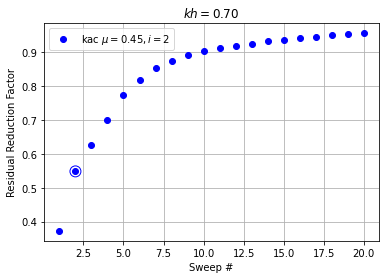

In [39]:
level = multilevel.level[1]
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

work = 1
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
title = "kac"
relax = kaczmarz
color = "blue"

relax = lambda x, b: level.relax(x, b)
factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, relax, (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=2, 
    num_examples=5, leeway_factor=leeway_factor)
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

nu_coarsest = num_sweeps

The coarse-level relaxation is still a good smoother, even though less effective than the fine-level relaxation. This means we built reasonable coarse-level equations that can be solved without advanced relaxation design techniques.

### Relaxation Cycle Shrinkage
We compare a two-level relaxation cycle with $\nu_1=1, \nu_2=1, \nu_{coarse}=$ # relaxations until the coarse-level relaxation slows down, with fine-level Kaczmarz relaxation.

2
INFO     Iter     |r|                 |x|         RER
INFO     0     1.220e+00            4.470e-01    2.731
INFO     1     6.912e-01 (0.566)    3.466e-01    2.000 (0.731)
INFO     2     4.179e-01 (0.605)    2.954e-01    1.423 (0.711)
INFO     3     2.710e-01 (0.649)    2.661e-01    1.027 (0.721)
INFO     4     1.918e-01 (0.708)    2.471e-01    0.783 (0.764)
INFO     5     1.487e-01 (0.775)    2.331e-01    0.643 (0.822)
INFO     6     1.222e-01 (0.821)    2.220e-01    0.555 (0.863)
INFO     7     1.055e-01 (0.863)    2.127e-01    0.500 (0.901)
INFO     8     9.397e-02 (0.890)    2.047e-01    0.463 (0.925)
INFO     9     8.526e-02 (0.907)    1.976e-01    0.435 (0.940)
INFO     10    7.831e-02 (0.918)    1.912e-01    0.413 (0.949)
INFO     11    7.254e-02 (0.926)    1.855e-01    0.394 (0.955)
INFO     Relax conv 0.93 shrinkage 0.66 PODR RER 0.64 after 5 sweeps. Work 1.0 eff 0.66
INFO     Iter     |r|                 |x|         RER
INFO     0     1.203e+00            4.470e-01    2.690

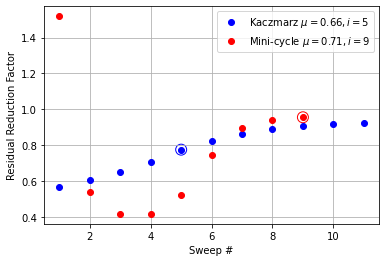

In [40]:
hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, nu_pre=1, nu_post=1, nu_coarsest=nu_coarsest)

#### Observations
* The first cycle increases the residual! Unless enough relaxations (4) are performed at the finest level.
* Convergence is faster than relaxation ($0.4$ vs. $0.6$) until the slowdown.
* The RER at the PODR is a lot smaller than in relaxation.

## Level 1->2 Coarsening

### Two-level Bootstrapping

In [41]:
num_examples = 20
max_levels = 2
num_bootstrap_steps = 1

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel1 = hm.hierarchy.multilevel.Multilevel(level)
_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((level.a.shape[0], num_examples))
factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, lambda x, b: level.relax(x, b), (level.a.shape[0], ), 
    print_frequency=None, max_sweeps=20, slow_conv_factor=1.1, leeway_factor=leeway_factor)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

# Start from random again. Level 0 doesn't exist here.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
x_log.append(x)

# Improve vectors with 1-level relaxation.
_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel1 = hm.setup.auto_setup.bootstap(
        x, multilevel1, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, neighborhood=neighborhood,
        repetitive=repetitive)
    x_log.append(x)
    r_log.append(multilevel1.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)
    
# Merge the 1-2 hierarchy into the 0-1 to create 0-1-2.
multilevel.level.append(multilevel1.level[1])

INFO     Relax at level 0 size 48
INFO     Relax conv 0.94 shrinkage 0.58 PODR RER 0.13 after 5 sweeps. Work 1.0 eff 0.58
INFO     Generating TVs with 5 sweeps
INFO     RER 0.137
INFO     bootstrap on grid size 48 with 2 levels
INFO     --------------------------------------------------------------------------------
INFO     Bootstrap step 1/1
INFO     Relax cycle conv factor 0.993 asymptotic RQ -0.027 RER 0.037 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     R (24, 48) a 6 nc 3 cr 0.50 mean_energy_error 0.0242; mock cycle nu 2 conv 0.14 eff 0.61
INFO     Mock cycle conv factor [0.322 0.13  0.087 0.054 0.025]
(120, 6) (120, 24)
(120, 6) (120, 24)
INFO     P max error: fit 0.017 val 0.014 test 0.041; alpha mean 0.000
INFO     fit  set size 15 P L2 error mean 0.02 max 0.04 A error mean 0.01 max 0.03
INFO     test set size 5  P L2 error mean 0.02 max 0.03 A error mean 0.02 max 0.02
INFO     Level 1 size 24
INFO     RER 0.068722
INFO  

Note that we are now able to reduce the RER of the TVs consisently with bootstrap cycles at level 1.

### Level 2 Relaxation Shrinkage

Level size 24
INFO     Iter     |r|                 |x|         RER
INFO     0     1.517e-01            4.452e-01    0.341
INFO     1     5.409e-02 (0.359)    3.317e-01    0.162 (0.480)
INFO     2     3.876e-02 (0.716)    2.862e-01    0.135 (0.829)
INFO     3     3.205e-02 (0.827)    2.573e-01    0.124 (0.920)
INFO     4     2.741e-02 (0.855)    2.354e-01    0.117 (0.935)
INFO     5     2.401e-02 (0.876)    2.178e-01    0.111 (0.947)
INFO     6     2.140e-02 (0.890)    2.030e-01    0.107 (0.957)
INFO     7     1.928e-02 (0.901)    1.900e-01    0.103 (0.964)
INFO     8     1.751e-02 (0.908)    1.784e-01    0.101 (0.969)
INFO     9     1.598e-02 (0.913)    1.679e-01    0.098 (0.973)
INFO     10    1.464e-02 (0.917)    1.583e-01    0.096 (0.975)
INFO     11    1.345e-02 (0.919)    1.496e-01    0.094 (0.977)
INFO     12    1.237e-02 (0.921)    1.415e-01    0.092 (0.977)
INFO     13    1.139e-02 (0.923)    1.342e-01    0.090 (0.977)
INFO     14    1.051e-02 (0.924)    1.275e-01    0.088 (0.

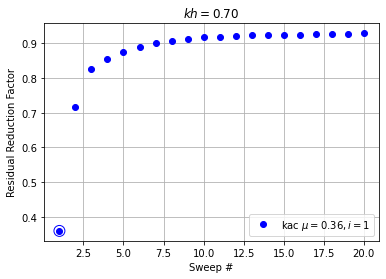

In [42]:
level = multilevel.level[2]
print("Level size {}".format(level.size))
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

work = 1
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
title = "kac"
relax = kaczmarz
color = "blue"

relax = lambda x, b: level.relax(x, b)
factor, num_sweeps, residual, conv, rer, conv_factor = hm.solve.smoothing.shrinkage_factor(
    level.operator, relax, (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=2, 
    num_examples=5, leeway_factor=leeway_factor)
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

nu_coarsest = num_sweeps

3
INFO     Iter     |r|                 |x|         RER
INFO     0     1.192e+00            4.470e-01    2.665
INFO     1     6.837e-01 (0.574)    3.475e-01    1.969 (0.739)
INFO     2     4.128e-01 (0.605)    2.973e-01    1.392 (0.707)
INFO     3     2.699e-01 (0.654)    2.693e-01    1.005 (0.722)
INFO     4     1.902e-01 (0.705)    2.515e-01    0.758 (0.755)
INFO     5     1.449e-01 (0.762)    2.390e-01    0.608 (0.803)
INFO     6     1.183e-01 (0.816)    2.293e-01    0.517 (0.851)
INFO     7     1.013e-01 (0.857)    2.213e-01    0.459 (0.888)
INFO     8     8.949e-02 (0.883)    2.145e-01    0.418 (0.911)
INFO     9     8.086e-02 (0.903)    2.086e-01    0.389 (0.929)
INFO     10    7.417e-02 (0.917)    2.033e-01    0.366 (0.941)
INFO     11    6.878e-02 (0.927)    1.984e-01    0.348 (0.950)
INFO     12    6.432e-02 (0.935)    1.941e-01    0.332 (0.956)
INFO     Relax conv 0.94 shrinkage 0.68 PODR RER 0.52 after 6 sweeps. Work 1.0 eff 0.68
INFO     Iter     |r|                 |x|    

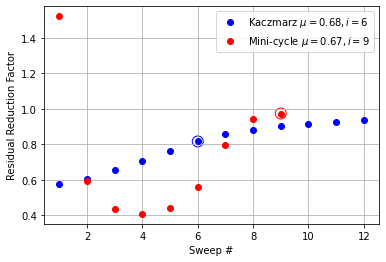

In [43]:
hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, max_sweeps=100,
    nu_pre=1, nu_post=1, nu_coarsest=3)

* Level 2 relaxation behaves weirdly: it slows down after exactly one sweep. One sweep is fast, then the residual reduction goes up, then down, then slowly back up again.
* The Level 1-2 min-cycle is not more efficient.

### Operators

#### Level 0

In [44]:
pd.DataFrame(multilevel.level[0].a[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-2.01,1.33,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.33,-2.01,1.33,-0.08,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.08,1.33,-2.01,1.33,-0.08,0.00,0.00,0.00,0.00,0.00
3,0.00,-0.08,1.33,-2.01,1.33,-0.08,0.00,0.00,0.00,0.00
4,0.00,0.00,-0.08,1.33,-2.01,1.33,-0.08,0.00,0.00,0.00
5,0.00,0.00,0.00,-0.08,1.33,-2.01,1.33,-0.08,0.00,0.00
6,0.00,0.00,0.00,0.00,-0.08,1.33,-2.01,1.33,-0.08,0.00
7,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.01,1.33,-0.08
8,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.01,1.33
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.01


#### Level 1

In [45]:
pd.DataFrame(multilevel.level[1].a[:18, :18].todense())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.15,-0.07,0.14,-0.25,0.00,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.07,-0.64,0.17,-0.27,0.01,-0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.14,0.17,0.15,-0.07,0.14,-0.25,0.00,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.25,-0.27,-0.07,-0.64,0.17,-0.27,0.01,-0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.01,0.14,0.17,0.15,-0.07,0.14,-0.25,0.00,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,-0.01,-0.02,-0.25,-0.27,-0.07,-0.64,0.17,-0.27,0.01,-0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.01,0.14,0.17,0.15,-0.07,0.14,-0.25,0.00,-0.01,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,-0.01,-0.02,-0.25,-0.27,-0.07,-0.64,0.17,-0.27,0.01,-0.02,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.01,0.14,0.17,0.15,-0.07,0.14,-0.25,0.00,-0.01,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,-0.01,-0.02,-0.25,-0.27,-0.07,-0.64,0.17,-0.27,0.01,-0.02,0.00,0.00,0.00,0.00


In [46]:
pd.DataFrame(multilevel.level[1].p[:18,:18].todense())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.31,-0.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.58,-0.42,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.63,0.32,-0.05,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.39,0.42,0.07,-0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.09,0.18,0.31,-0.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,-0.06,-0.10,0.58,-0.42,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.63,0.32,-0.05,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.39,0.42,0.07,-0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.09,0.18,0.31,-0.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,-0.06,-0.10,0.58,-0.42,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### Level 2

In [47]:
pd.DataFrame(multilevel.level[2].a[:18, :18].todense())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.13,-0.10,-0.24,0.02,0.02,-0.13,0.02,-0.02,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.10,-0.08,-0.04,-0.13,0.07,-0.22,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.24,-0.04,-0.35,-0.06,-0.01,0.06,-0.01,0.02,-0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.02,-0.13,-0.06,-0.13,-0.10,-0.24,0.02,0.02,-0.13,0.02,-0.02,0.06,0.00,0.00,0.00,0.00,0.00,0.00
4,0.02,0.07,-0.01,-0.10,-0.08,-0.04,-0.13,0.07,-0.22,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,-0.13,-0.22,0.06,-0.24,-0.04,-0.35,-0.06,-0.01,0.06,-0.01,0.02,-0.04,0.00,0.00,0.00,0.00,0.00,0.00
6,0.02,0.00,-0.01,0.02,-0.13,-0.06,-0.13,-0.10,-0.24,0.02,0.02,-0.13,0.02,-0.02,0.06,0.00,0.00,0.00
7,-0.02,-0.00,0.02,0.02,0.07,-0.01,-0.10,-0.08,-0.04,-0.13,0.07,-0.22,0.00,-0.00,0.00,0.00,0.00,0.00
8,0.06,0.00,-0.04,-0.13,-0.22,0.06,-0.24,-0.04,-0.35,-0.06,-0.01,0.06,-0.01,0.02,-0.04,0.00,0.00,0.00
9,0.00,0.00,0.00,0.02,0.00,-0.01,0.02,-0.13,-0.06,-0.13,-0.10,-0.24,0.02,0.02,-0.13,0.02,-0.02,0.06


In [48]:
pd.DataFrame(multilevel.level[2].p[:18, :18].todense())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.11,0.49,-0.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.66,0.01,0.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.48,-0.50,-0.49,0.08,-0.19,0.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.62,-0.38,0.39,-0.10,0.13,-0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.34,0.35,0.45,0.02,-0.11,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.25,0.25,0.08,-0.21,0.01,-0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.06,-0.06,-0.10,-0.11,0.49,-0.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.19,0.04,-0.12,0.66,0.01,0.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,-0.06,-0.01,0.03,0.48,-0.50,-0.49,0.08,-0.19,0.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.12,0.01,-0.07,-0.62,-0.38,0.39,-0.10,0.13,-0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [49]:
multilevel.level[0].a[10], multilevel.level[1].a[10], multilevel.level[2].a[10]

(<1x96 sparse matrix of type '<class 'numpy.float64'>'
 	with 5 stored elements in Compressed Sparse Row format>,
 <1x48 sparse matrix of type '<class 'numpy.float64'>'
 	with 10 stored elements in Compressed Sparse Column format>,
 <1x24 sparse matrix of type '<class 'numpy.float64'>'
 	with 15 stored elements in Compressed Sparse Column format>)

In [50]:
a2 = multilevel.level[1].a
print(a2[0].todense())
rap = (multilevel.level[1].r.dot(a0).dot(multilevel.level[1].p))
print(rap[0].todense())
# P^T*A*P is not too far from R*A*P.
print(scipy.sparse.linalg.norm(rap - a2, ord="fro"), scipy.sparse.linalg.norm(a2, ord="fro"))

[[ 0.149 -0.074  0.142 -0.252  0.005 -0.011  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.005  0.008  0.142  0.174]]
[[ 0.134 -0.065  0.127 -0.227  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.131  0.163]]
0.9477134158383852 4.4222323236127155


## How Does the Coarse Variables Look Like?
Print rows of $R_L \cdot \dots \cdot R_1$ and columns of $P_1 \cdot \dots \cdot P_L$ (for $L$ levels of coarsening).

In [51]:
r1 = multilevel.level[1].r
p1 = multilevel.level[1].p

r2 = multilevel.level[2].r
p2 = multilevel.level[2].p

p = p1.dot(p2)
r = r2.dot(r1)

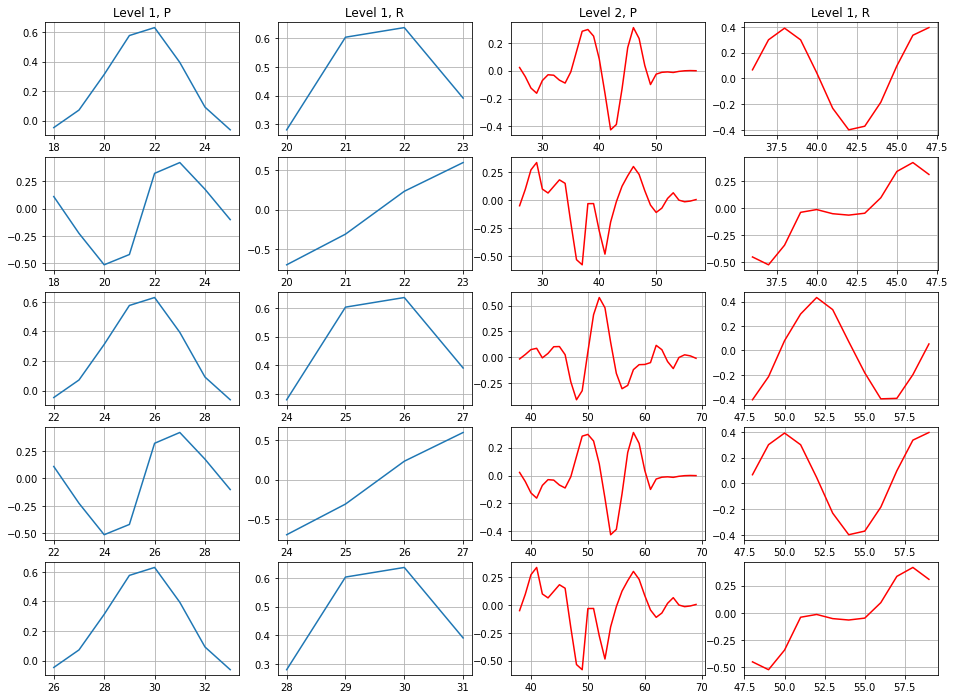

In [52]:
num_vars = 5
fig, axs = plt.subplots(num_vars, 4, figsize=(16, 12))
start_index = 10

col_titles = ("Level 1, P", "Level 1, R", "Level 2, P", "Level 1, R") 
for ax, col in zip(axs[0], col_titles):
    ax.set_title(col)
    
for i in range(num_vars):
    j = start_index + i
    
    ax = axs[i, 0]
    ax.plot(p1[:, j].nonzero()[0], p1[:, j].data)
    ax.grid(True)
    
    ax = axs[i, 1]
    ax.plot(r1[j].nonzero()[1], r1[j].data)
    ax.grid(True)
    
    ax = axs[i, 2]
    ax.plot(p[:, j].nonzero()[0], p[:, j].data, "r")
    ax.grid(True)
    
    ax = axs[i, 3]
    ax.plot(r[j].nonzero()[1], r[j].data, "r")
    ax.grid(True)

## Level 2 has a new AZM!

In [53]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel.level):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:13])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel.level)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel.level[k].p.dot(v)
    vl_finest.append(v)

0 lam [-0.027 -0.027  0.062  0.062 -0.124 -0.124  0.143  0.143  0.216  0.216 -0.23  -0.23   0.28 ]
1 lam [-0.029 -0.029  0.063  0.063 -0.127 -0.13   0.147  0.147  0.222  0.222 -0.232 -0.232  0.285]
2 lam [-0.029 -0.029  0.054  0.054  0.081  0.081 -0.103 -0.114 -0.114  0.135  0.135 -0.135  0.174]


### What Level 1 eigenvectors comprise the level 2 AZM?
We calculate $(v^2_i)^T (R_2 v^1)$, which gives us the spectral decomposition coefficients of the level 2 eigenvector $v^2_i$ in terms of the coarsened level 1 eigenvectors.

/Users/olivne/.conda/envs/hm/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/olivne/.conda/envs/hm/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/olivne/.conda/envs/hm/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/olivne/.conda/envs/hm/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/olivne/.conda/envs/hm/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  ret

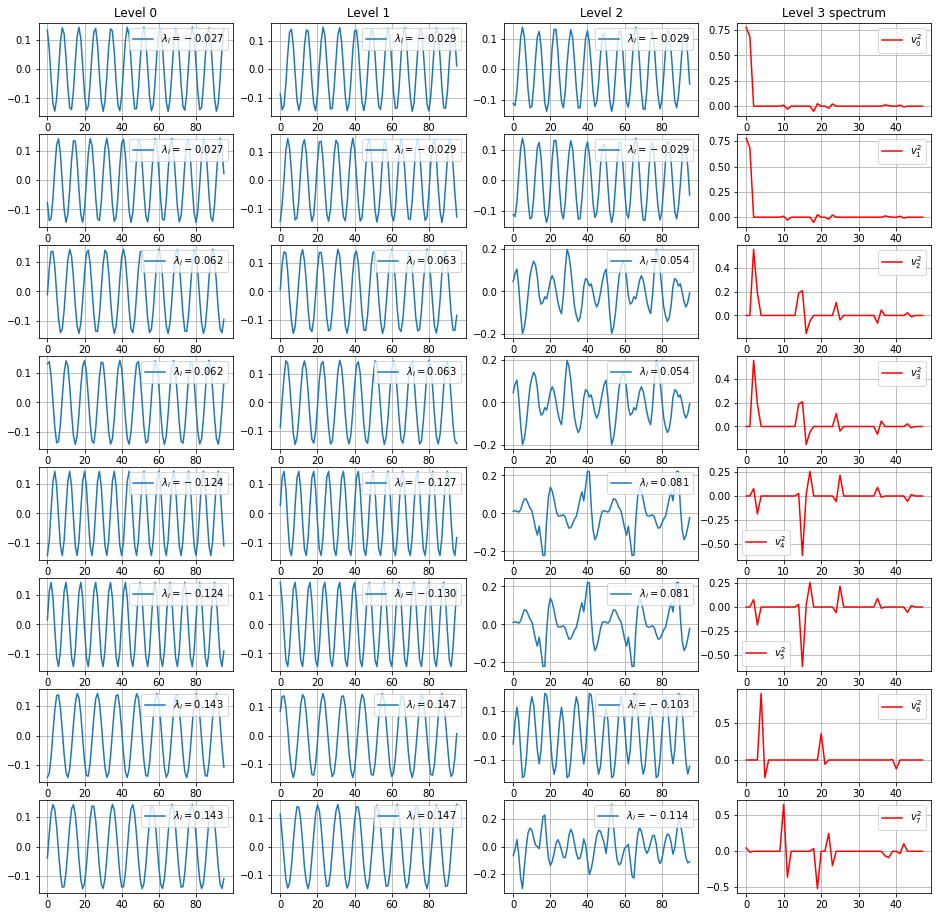

In [54]:
num_ev = 8
fig, axs = plt.subplots(num_ev, num_levels + 1, figsize=(16, 16))

for col, ax in enumerate(axs[0][:-1]):
    ax.set_title("Level {}".format(col))
axs[0, -1].set_title("Level {} spectrum".format(num_levels))

for i in range(num_ev):
    for l in range(num_levels):
        ax = axs[i, l]
        ax.plot(vl_finest[l][:, i], label="$\lambda_i = {:.3f}$".format(laml[l][i]))
        ax.legend(loc="upper right")
        ax.grid(True);
        
composition = (r2.dot(vl[1])).transpose().dot(vl[2])
for i in range(num_ev):
    ax = axs[i, num_levels]
    ax.plot(composition[:, i], "r", label = "$v^2_{}$".format(i))
    ax.grid(True)
    ax.legend();

While several vectors (e.g., $v^2_1, v^2_2$) mainly correspond to a single level 1 component, the AZM $v_2^0$ and one other aer composed of many eigenvectors.

## Does the non-repetitiveness cause locally bad $P/A^C$ that can explain the AZM?
The AZM seems like it's generated by noise. If we used sampling and a uniform stencil $[A^c]$ over the domain, this would probably be avoided. Let's check if $A^1$'s coefficients vary across the domain.

In [55]:
a1 = multilevel.level[1].a
data = np.vstack((a1.nonzero()[1] - a1.nonzero()[0], a1.data)).transpose()
data[data[:, 0] > a.shape[0] // 2, 0] = data[data[:, 0] > a.shape[0] // 2, 0] - a1.shape[0]

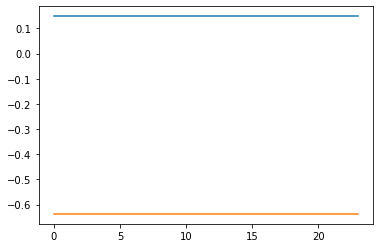

In [56]:
plt.plot(data[data[:, 0] == 0, 1][::2])
plt.plot(data[data[:, 0] == 0, 1][1::2]);

In [57]:
for i in range(12, 32):
    print(i, a1[i].data)

12 [ 0.005  0.008  0.142  0.174  0.149 -0.074  0.142 -0.252  0.005 -0.011]
13 [-0.011 -0.018 -0.252 -0.272 -0.074 -0.637  0.174 -0.272  0.008 -0.018]
14 [ 0.005  0.008  0.142  0.174  0.149 -0.074  0.142 -0.252  0.005 -0.011]
15 [-0.011 -0.018 -0.252 -0.272 -0.074 -0.637  0.174 -0.272  0.008 -0.018]
16 [ 0.005  0.008  0.142  0.174  0.149 -0.074  0.142 -0.252  0.005 -0.011]
17 [-0.011 -0.018 -0.252 -0.272 -0.074 -0.637  0.174 -0.272  0.008 -0.018]
18 [ 0.005  0.008  0.142  0.174  0.149 -0.074  0.142 -0.252  0.005 -0.011]
19 [-0.011 -0.018 -0.252 -0.272 -0.074 -0.637  0.174 -0.272  0.008 -0.018]
20 [ 0.005  0.008  0.142  0.174  0.149 -0.074  0.142 -0.252  0.005 -0.011]
21 [-0.011 -0.018 -0.252 -0.272 -0.074 -0.637  0.174 -0.272  0.008 -0.018]
22 [ 0.005  0.008  0.142  0.174  0.149 -0.074  0.142 -0.252  0.005 -0.011]
23 [-0.011 -0.018 -0.252 -0.272 -0.074 -0.637  0.174 -0.272  0.008 -0.018]
24 [ 0.005  0.008  0.142  0.174  0.149 -0.074  0.142 -0.252  0.005 -0.011]
25 [-0.011 -0.018 -0.252 